In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pandas as pd
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, Input, Bidirectional, GRU, Average
from sklearn.metrics import mean_squared_error

from PyEMD import EMD
import CEEMDAN_LSTM as cl

Importing...Finished. Use cl.guideline() to call for a guideline or cl.example() for an exmple.


In [2]:
df_path = "data/one_year_complete.csv"
org_df = pd.read_csv(df_path,sep=',')
org_df['date'] = pd.to_datetime(org_df['date'])
org_df = org_df.set_index('date')
org_df.head(10)

,open,high,low,close,Volume BTC,tradecount,pos,neg,neu
date,,,,,,,,,
2021-01-01,28923.63,29600.00,28624.57,29331.69,54182.92501,1314910,0.45845,0.05001,0.49154
2021-01-02,29331.70,33300.00,28946.53,32178.33,129993.87340,2245922,0.57480,0.05203,0.37317
2021-01-03,32176.45,34778.11,31962.99,33000.05,120957.56680,2369698,0.48389,0.05885,0.45726
2021-01-04,33000.05,33600.00,28130.00,31988.71,140899.88570,2642408,0.38149,0.08008,0.53843
2021-01-05,31989.75,34360.00,29900.00,33949.53,116049.99700,2526851,0.52304,0.08422,0.39274
2021-01-06,33949.53,36939.21,33288.00,36769.36,127139.20130,2591783,0.45125,0.10656,0.44219
2021-01-07,36769.36,40365.00,36300.00,39432.28,132825.70040,2814686,0.47229,0.08922,0.43849
2021-01-08,39432.48,41950.00,36500.00,40582.81,139789.95750,2925632,0.58689,0.10403,0.30908
2021-01-09,40586.96,41380.00,38720.00,40088.22,75785.97968,1998156,0.33868,0.11207,0.54925


In [3]:
ns_df = org_df[['open','high', 'low', 'close', 'Volume BTC']]  #nonsentimental df
ns_df.head(5)

,open,high,low,close,Volume BTC
date,,,,,
2021-01-01,28923.63,29600.00,28624.57,29331.69,54182.92501
2021-01-02,29331.70,33300.00,28946.53,32178.33,129993.87340
2021-01-03,32176.45,34778.11,31962.99,33000.05,120957.56680
2021-01-04,33000.05,33600.00,28130.00,31988.71,140899.88570
2021-01-05,31989.75,34360.00,29900.00,33949.53,116049.99700


In [4]:
# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)

In [5]:
def get_model(params, input_shape, num_features):
    if (params["model_type"] == "lstm"):
        #print(params["expr_name"] +"/"+ params["model_type"])
        model = Sequential()
        model.add(LSTM(params["lstm_units"], input_shape=(input_shape,num_features)))
        model.add(Dense(1))
        model.compile(loss=params["loss"], optimizer=params["optimizer"])
        return model
    elif (params["model_type"] == "stacked_lstm"):
        #print(params["expr_name"] +"/"+ params["model_type"])
        model = Sequential()
        model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, num_features)))
        model.add(Dropout(rate=params["dropout"]))
        model.add(LSTM(units=int(params["lstm_units"] / 2), return_sequences=False))
        model.add(Dropout(rate=params["dropout"]))
        model.add(Dense(1))
        model.compile(loss=params["loss"],optimizer=params["optimizer"])
        return model
    elif (params["model_type"] == "bidirectional_lstm"):
        #print(params["expr_name"] +"/"+ params["model_type"])
        model = Sequential()
        model.add(Bidirectional(LSTM(units=params["lstm_units"], return_sequences=True, dropout=params["dropout"], input_shape=(input_shape, num_features))))
        model.add(Bidirectional(LSTM(units=int(params["lstm_units"] / 2) , dropout=params["dropout"], return_sequences=False)))
        model.add(Dense(1))
        model.compile(loss=params["loss"],optimizer=params["optimizer"])
        return model
    elif (params["model_type"] == "gru"):
        #print(params["expr_name"] +"/"+ params["model_type"])
        model = Sequential()
        model.add(GRU(units=params["lstm_units"], input_shape=(input_shape, num_features), activation='tanh'))
        model.add(Dropout(rate=params["dropout"]))
        model.add(Dense(1))
        model.compile(loss=params["loss"],optimizer=params["optimizer"])
        return model
    elif (params["model_type"] == "stacked_gru"):
        #print(params["expr_name"] +"/"+ params["model_type"])
        model = Sequential()
        model.add(GRU(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, num_features), activation='tanh'))
        model.add(Dropout(rate=params["dropout"]))
        model.add(GRU(units=int(params["lstm_units"] / 2), return_sequences=False, activation='tanh'))
        model.add(Dropout(rate=params["dropout"]))
        model.add(Dense(1))
        model.compile(loss=params["loss"],optimizer=params["optimizer"])
        return model
    elif (params["model_type"] == "bidirectional_gru"):
        #print(params["expr_name"] +"/"+ params["model_type"])
        model = Sequential()
        model.add(Bidirectional(GRU(units=params["lstm_units"], return_sequences=True, dropout=params["dropout"], input_shape=(input_shape, num_features), activation='tanh')))
        model.add(Bidirectional(GRU(units=int(params["lstm_units"] / 2) , dropout=params["dropout"], return_sequences=False, activation='tanh')))
        model.add(Dense(1))
        model.compile(loss=params["loss"],optimizer=params["optimizer"])
        return model
    elif (params["model_type"] == "1dcnn_lstm"):
        #print(params["expr_name"] +"/"+ params["model_type"])
        input_layer = Input(shape=(input_shape, num_features))
        conv1 = Conv1D(filters=params["lstm_units"],
               kernel_size=3,
               strides=1,
               activation='relu',
               padding='same')(input_layer)
        lstm1 = LSTM(units=params["lstm_units"])(conv1)
        output_layer = Dense(1, activation='sigmoid')(lstm1)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(loss=params["loss"],optimizer=params["optimizer"])
        return model
    elif (params["model_type"] == "1dcnn_gru"):
        #print(params["expr_name"] +"/"+ params["model_type"])
        input_layer = Input(shape=(input_shape, num_features))
        conv1 = Conv1D(filters=params["lstm_units"],
               kernel_size=3,
               strides=1,
               activation='relu',
               padding='same')(input_layer)
        gru1 = GRU(units=params["lstm_units"], activation='tanh')(conv1)
        output_layer = Dense(1, activation='tanh')(gru1)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(loss=params["loss"],optimizer=params["optimizer"])
        return model
    

In [6]:
def evaluateModel(df, params):
    expr_name = params['expr_name']
    look_back = params['look_back']
    lstm_units = params['lstm_units']
    epochs=params['epochs']
    batch_size=params['batch_size']
    train_size_percent = params['train_size_percent']
    plot = params['plot']
    #scale data
    dataset = df.values
    dataset = dataset.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    num_of_features = len(df.columns)
    #split data
    pred_col = df.columns.get_loc('close')
    train_size = int(len(dataset) * train_size_percent)
    test_size = len(dataset) - train_size
    print(train_size, test_size)
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

    trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
    testX, testY = create_dataset(test, pred_col, look_back=look_back)
    # reshape input to be  [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
    testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))    
    print(len(trainX), len(testX))
    print(len(trainY), len(testY))
    # create and fit the LSTM network
    #model = Sequential()
    #model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
    #model.add(Dense(1))
    #model.compile(loss='mean_squared_error', optimizer='adam')
    model = get_model(params, look_back, num_of_features)
    history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False, verbose=0)
    if (plot):
        # Plot training
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['training', 'validation'], loc='upper right')
        plt.show()
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    print(len(trainPredict), len(testPredict))
    # Get something which has as many features as dataset
    trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
    # Put the predictions there
    trainPredict_extended[:,pred_col] = trainPredict[:,0]
    # Inverse transform it and select the 3rd column.
    trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

    # Get something which has as many features as dataset
    testPredict_extended = np.zeros((len(testPredict),num_of_features))
    # Put the predictions there
    testPredict_extended[:,pred_col] = testPredict[:,0]
    # Inverse transform it and select the pred_col column.
    testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

    trainY_extended = np.zeros((len(trainY),num_of_features))
    trainY_extended[:,pred_col]=trainY
    trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

    testY_extended = np.zeros((len(testY),num_of_features))
    testY_extended[:,pred_col]=testY
    testY = scaler.inverse_transform(testY_extended)[:,pred_col]

    # calculate root mean squared error
    trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
    testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

    # calculate absolute mean error
    trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
    testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)
    
    if (plot):
        # shift train predictions for plotting
        trainPredictPlot = np.empty_like(dataset)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

        # shift test predictions for plotting
        testPredictPlot = np.empty_like(dataset)
        testPredictPlot[:, :] = np.nan
        testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

        # contruct pandas dataframe for plotting
        time_df = pd.DataFrame(df.index)
        time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
        df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
        df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
        time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
        time_df2.set_index('date',inplace=True)

        # plot the output
        fig, ax = plt.subplots(figsize=(15,7))
        time_df2.plot(ax=ax,rot=90,alpha=0.7)
        plt.xlabel('date')
        plt.ylabel('Bitcoin Value')
        plt.title('Bitcoin Price Prediction')
        plt.savefig(expr_name + '.png',bbox_inches = "tight")
        print('-' * 50)
        print('Experiment name:', expr_name)

        print('-' * 50)
        print('look_back days:', look_back/24)
        print('lstm_units:', lstm_units)
        print('epochs:', epochs)
        print('batch_size:', batch_size)
        print('dataset features', list(df.columns))


        print('-' * 50)
        print('Train Score: %.2f RMSE' % (trainScore_RMSE))
        print('Test Score: %.2f RMSE' % (testScore_RMSE))

        print('-' * 50)
        print('Train Score: %.2f MAE' % (trainScore_MAE))
        print('Test Score: %.2f MAE' % (testScore_MAE))

        print('-' * 50)
        print('Model summary:')
        model.summary()
    
    return trainScore_RMSE, testScore_RMSE, trainScore_MAE, testScore_MAE, trainPredict, testPredict, len(testPredict), trainY, testY

In [7]:
#best params after some tests
''' model_types: lstm, stacked_lstm, bidirectional_lstm, gru, stacked_gru, 1dcnn_lstm, 1dcnn_gru'''
params = { "expr_name" : "sentiment", 
          "model_type" :"lstm",
          "look_back" : 7 ,
          "lstm_units" :  256,
          "loss": "mean_squared_error",
          "optimizer": "adam",
          "dropout": 0.2,
          "epochs" : 100,
          "batch_size" : 16,
          "train_size_percent" :  0.80,
          "plot" : False
}

In [8]:
train_RMSE, test_RMSE, train_MAE, test_MAE, train_predict, test_predict, period, trainY, testY = evaluateModel(org_df, params)
metrics = {'expr_name': params["expr_name"], 'model_type': params["model_type"], 'lstm_units': params["lstm_units"], 'batch_size': params["batch_size"],
        'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'train_MAE': train_MAE, 'test_MAE': test_MAE}

296 75
288 67
288 67
288 67


In [9]:
metrics

{'expr_name': 'sentiment',
 'model_type': 'lstm',
 'lstm_units': 256,
 'batch_size': 16,
 'train_RMSE': 2102.1940335045197,
 'test_RMSE': 2039.8884173950091,
 'train_MAE': 1638.9357697166854,
 'test_MAE': 1580.0869188579552}

In [10]:
test_predict

array([60077.74797469, 59267.087364  , 58907.22427981, 61292.65980687,
       59765.08684141, 58778.62207055, 58955.64646056, 60200.43571166,
       61372.83528227, 65089.03618071, 66200.0190333 , 63247.7275512 ,
       62605.59069944, 62578.35407648, 62954.88604677, 63652.77556457,
       63719.13239224, 60284.87743843, 59160.58588491, 57404.73887579,
       57102.14919186, 58813.69457252, 58241.87574235, 55989.0719149 ,
       55963.21943325, 54981.03457306, 57141.33313992, 54404.40767304,
       53304.47063244, 55255.59084215, 57145.35807718, 56595.97235322,
       56319.93632779, 55764.29920241, 53589.72667818, 49277.44805169,
       48546.51215985, 49530.39532502, 50371.11092538, 49933.4991662 ,
       48397.35158185, 47337.52732098, 47519.79460155, 49027.92015379,
       47338.25012504, 47155.00279045, 47811.57409623, 47657.67715964,
       46446.06518412, 46722.81376914, 46677.32605905, 46987.68104898,
       48000.80761438, 48492.60349787, 50737.55778704, 50828.84281778,
      

In [11]:
#emd part
df = pd.read_csv('data/one_year_complete.csv')
df = df.sort_values(by='date',ascending=False)
df.head()

,date,open,high,low,close,Volume BTC,tradecount,pos,neg,neu
251,9/9/2021 0:00,46048.31,47399.97,45513.08,46395.14,50651.66002,1567586,0.51376,0.08145,0.40479
250,9/8/2021 0:00,46868.57,47340.99,44412.02,46048.31,65069.31520,1796101,0.49190,0.12799,0.38011
249,9/7/2021 0:00,52666.20,52920.00,42843.05,46863.73,123048.80270,3321711,0.36441,0.11258,0.52301
248,9/6/2021 0:00,51756.88,52780.00,50969.33,52663.90,49249.66708,1678015,0.46892,0.07386,0.45722
247,9/5/2021 0:00,49917.54,51900.00,49450.00,51756.88,40544.83587,1417660,0.51123,0.10591,0.38286


Saving path: data\
Get input series named: close


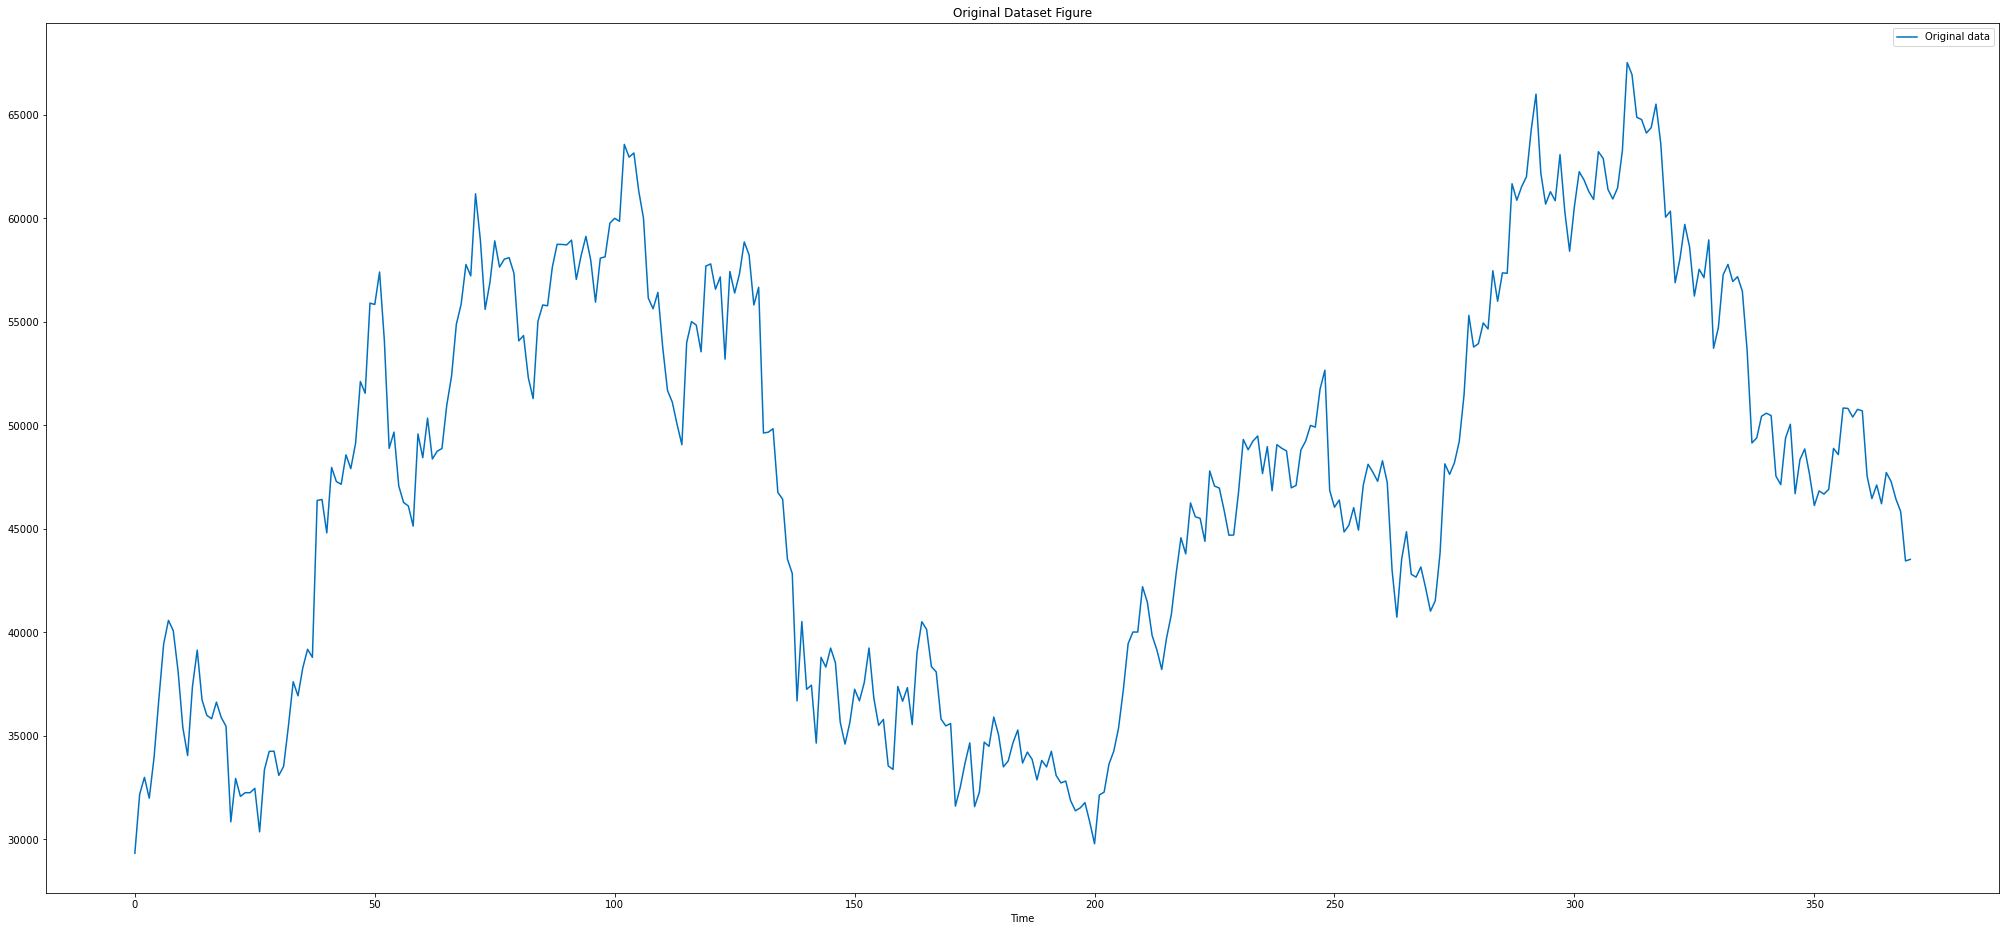

In [12]:
PATH = 'data\\'
FIGURE_PATH = PATH+'figures'
LOG_PATH = PATH+'subset'
DATASET_NAME = 'one_year_complete.csv'
SERIES = pd.Series(df['close'])
PERIODS = period  
series = cl.declare_path(path=PATH,figure_path=FIGURE_PATH,log_path=LOG_PATH,dataset_name=DATASET_NAME,series=SERIES)

In [14]:
#cl.statistical_tests()

##################################
Global Variables
##################################
MODE:EMD
FORM:
DATE_BACK:30
PERIODS:67
EPOCHS:100
PATIENCE:10
EMD decomposition is running.


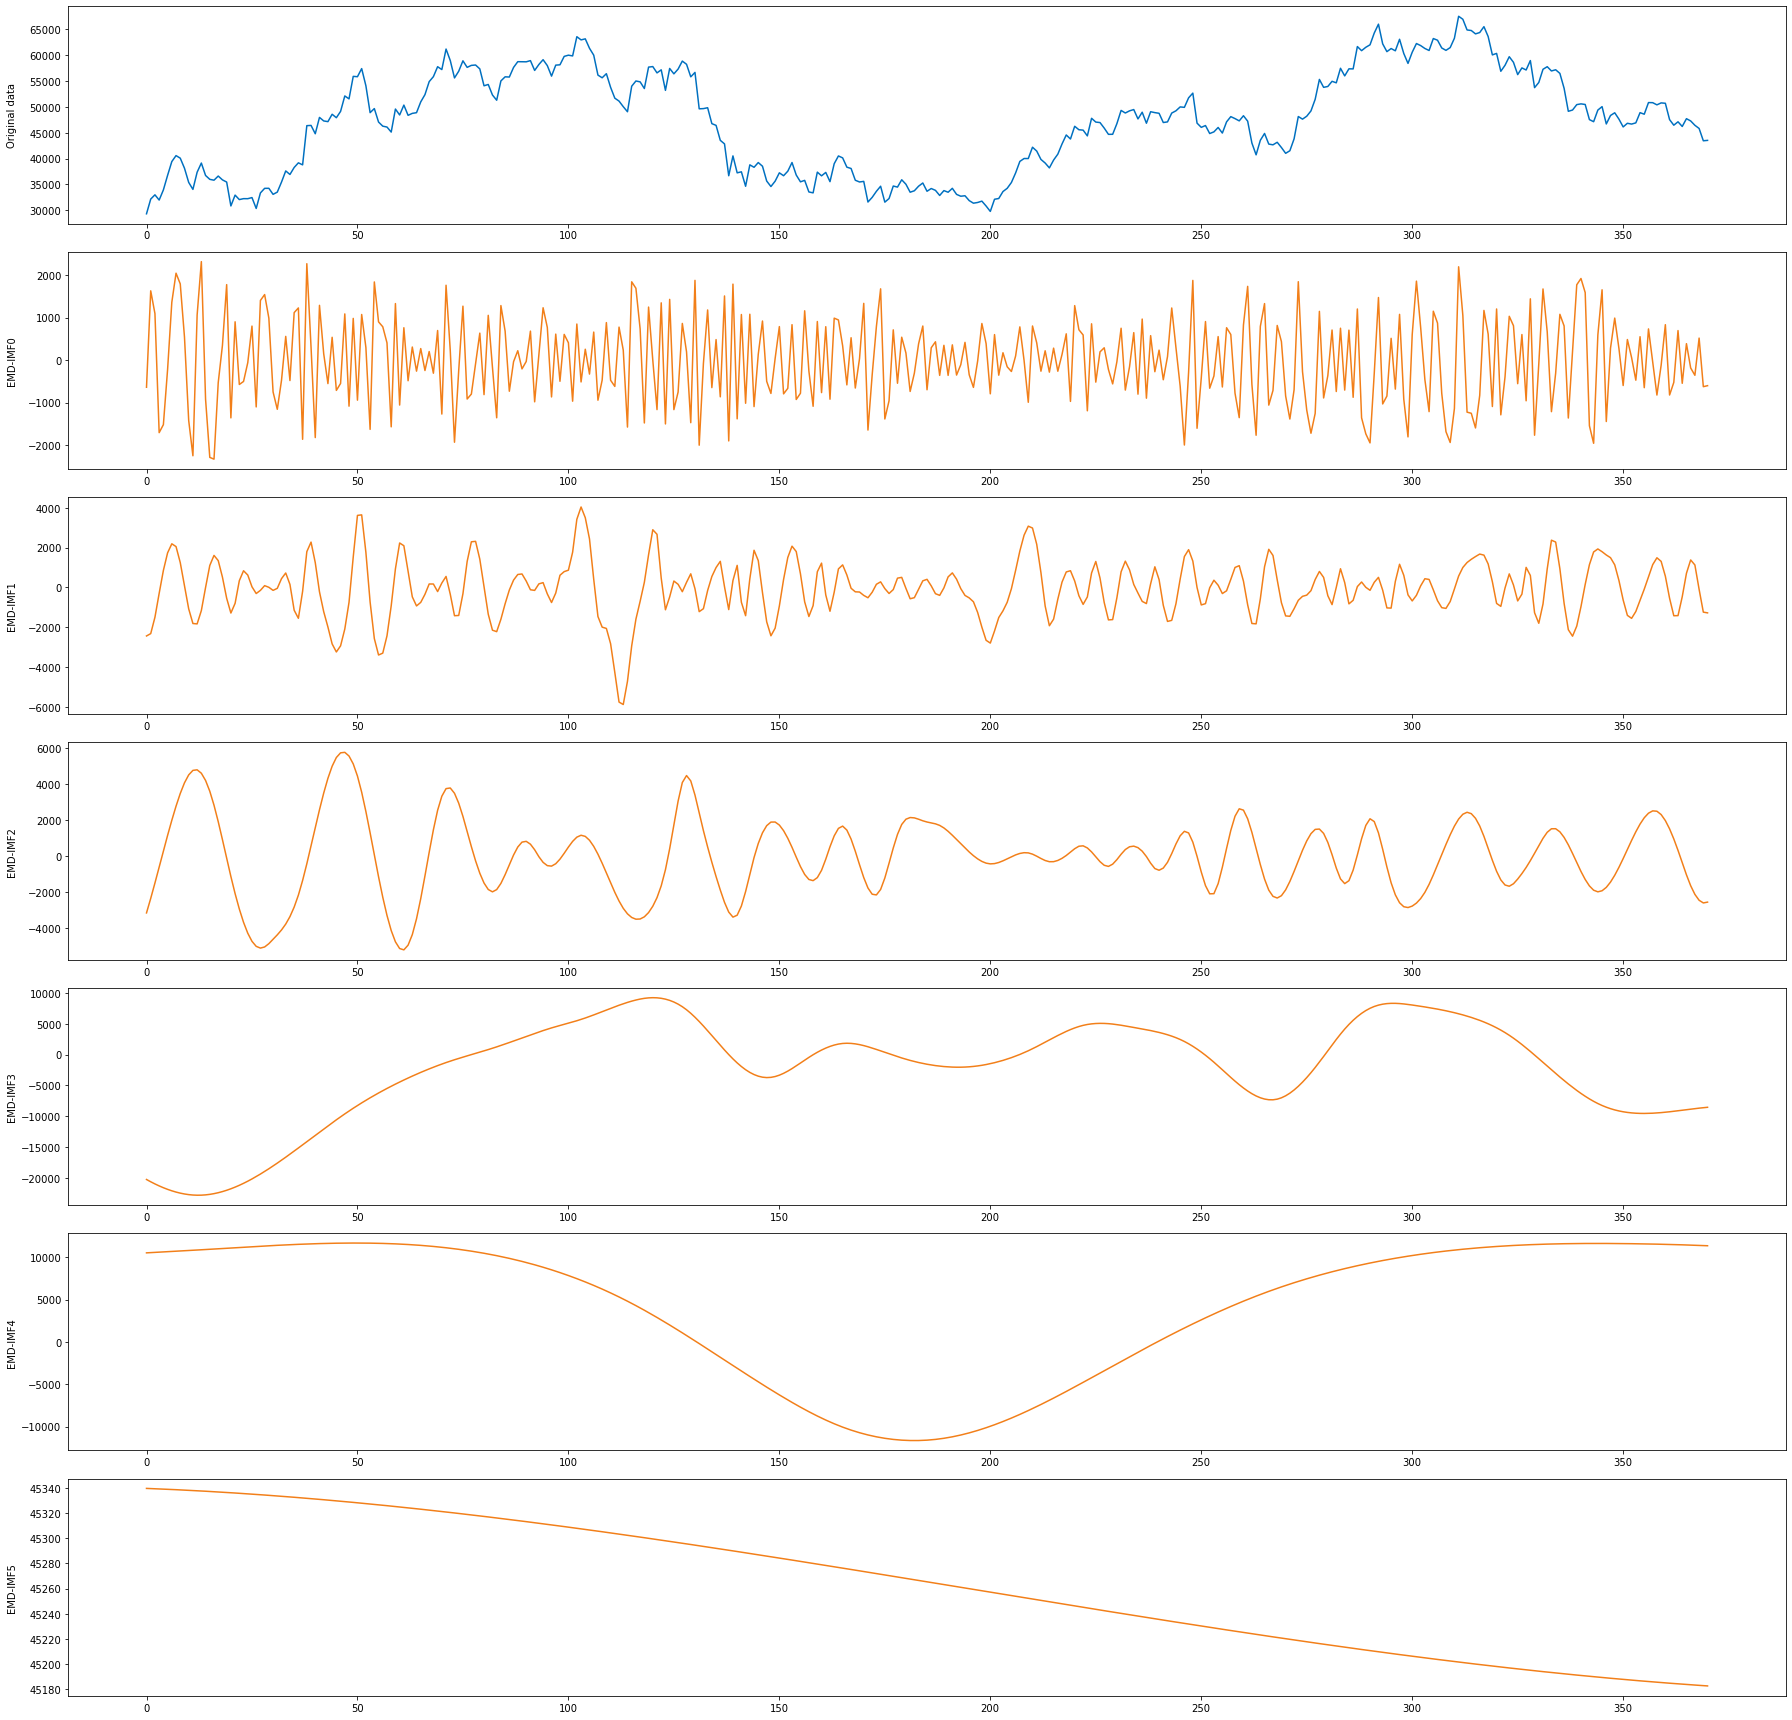

EMD finished, check the dataset:  data\emd_data.csv
Sample entropy of EMD is running.


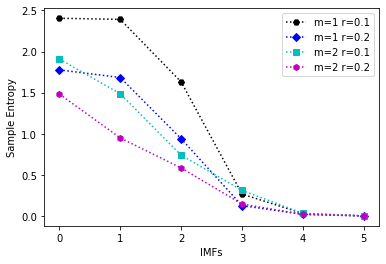

In [15]:
# EMD and its SE
cl.declare_vars(mode='emd', periods=PERIODS)
imfs_emd = cl.emd_decom()
cl.sample_entropy() # SE

The Integrating Form: 222


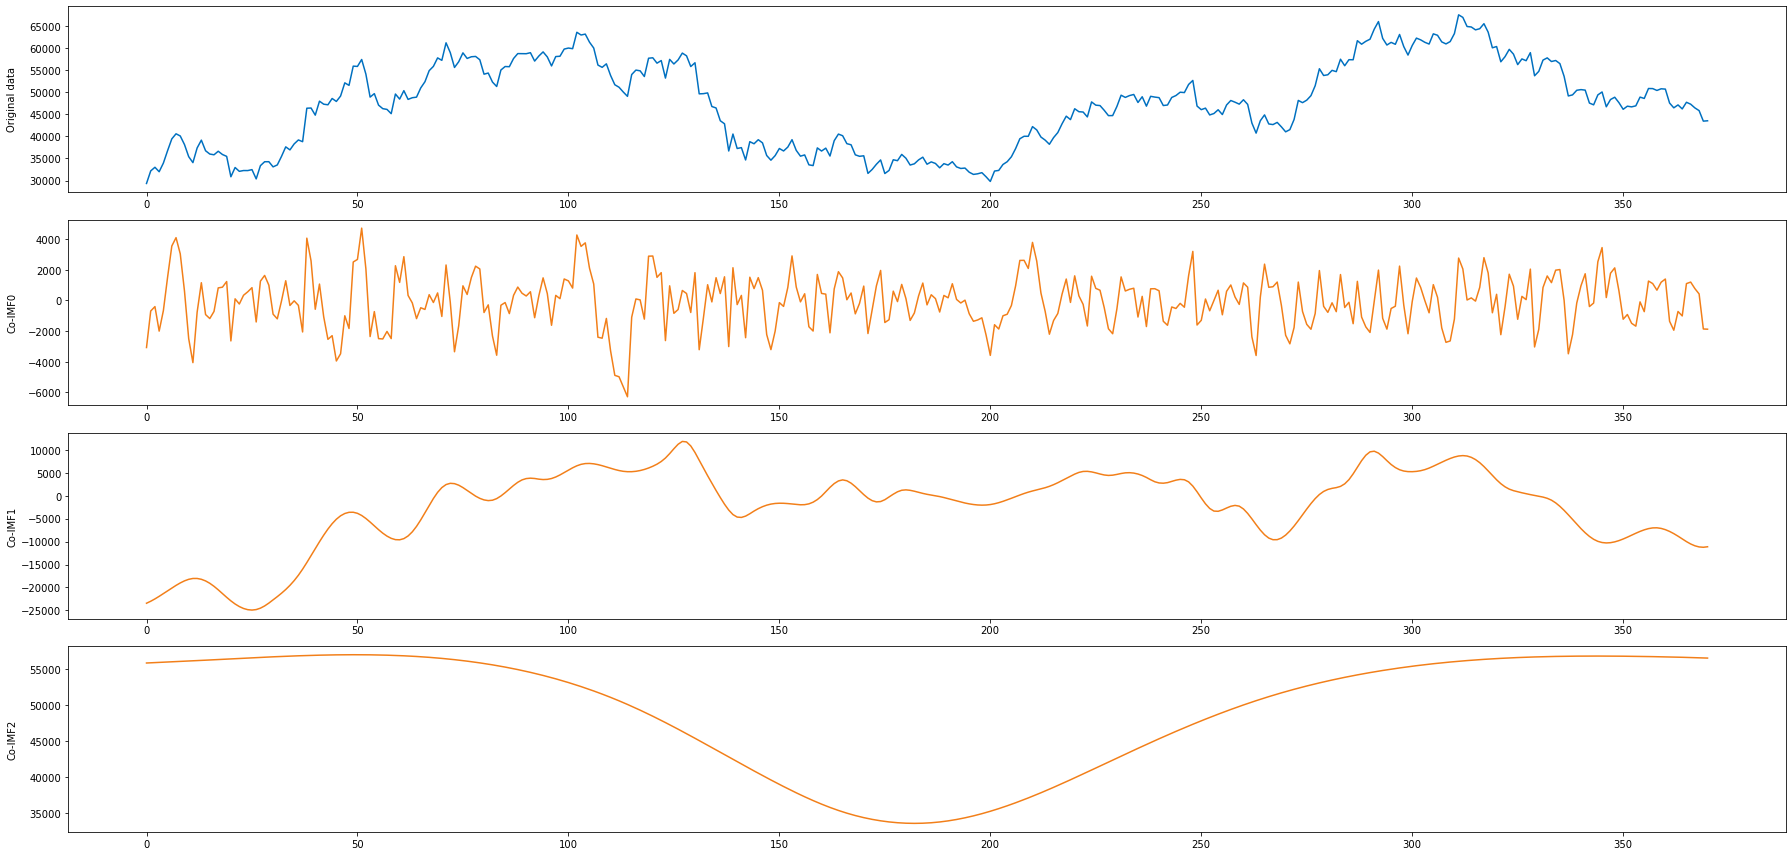

Integration finished, check the dataset:  data\emd_se222_data.csv


In [16]:
form = [[0,1],[2,3],[4,5]] # form 233
cl.integrate(inte_form=form) 

##################################
Global Variables
##################################
MODE:EMD_SE
FORM:222
DATE_BACK:30
PERIODS:67
EPOCHS:1000
PATIENCE:100
This is Respective LSTM Forecasting running...
Part of Inputting dataset:
         co-imf0       co-imf1       co-imf2
0   -3073.631228 -23445.520169  55850.841397
1    -689.404082 -23010.082208  55877.816290
2    -402.648844 -22502.098462  55904.797306
3   -2002.139445 -21940.969589  55931.819034
4    -663.289815 -21346.096246  55958.916061
..           ...           ...           ...
366  1196.468773 -10519.714703  56609.425930
367   771.227108 -10916.707876  56591.580768
368   422.960403 -11163.814431  56572.864028
369 -1863.270017 -11238.854644  56553.254661
370 -1876.935269 -11127.796350  56532.731619

[371 rows x 3 columns]
EMD_SE--IMF0

Input Shape: (30,1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)   

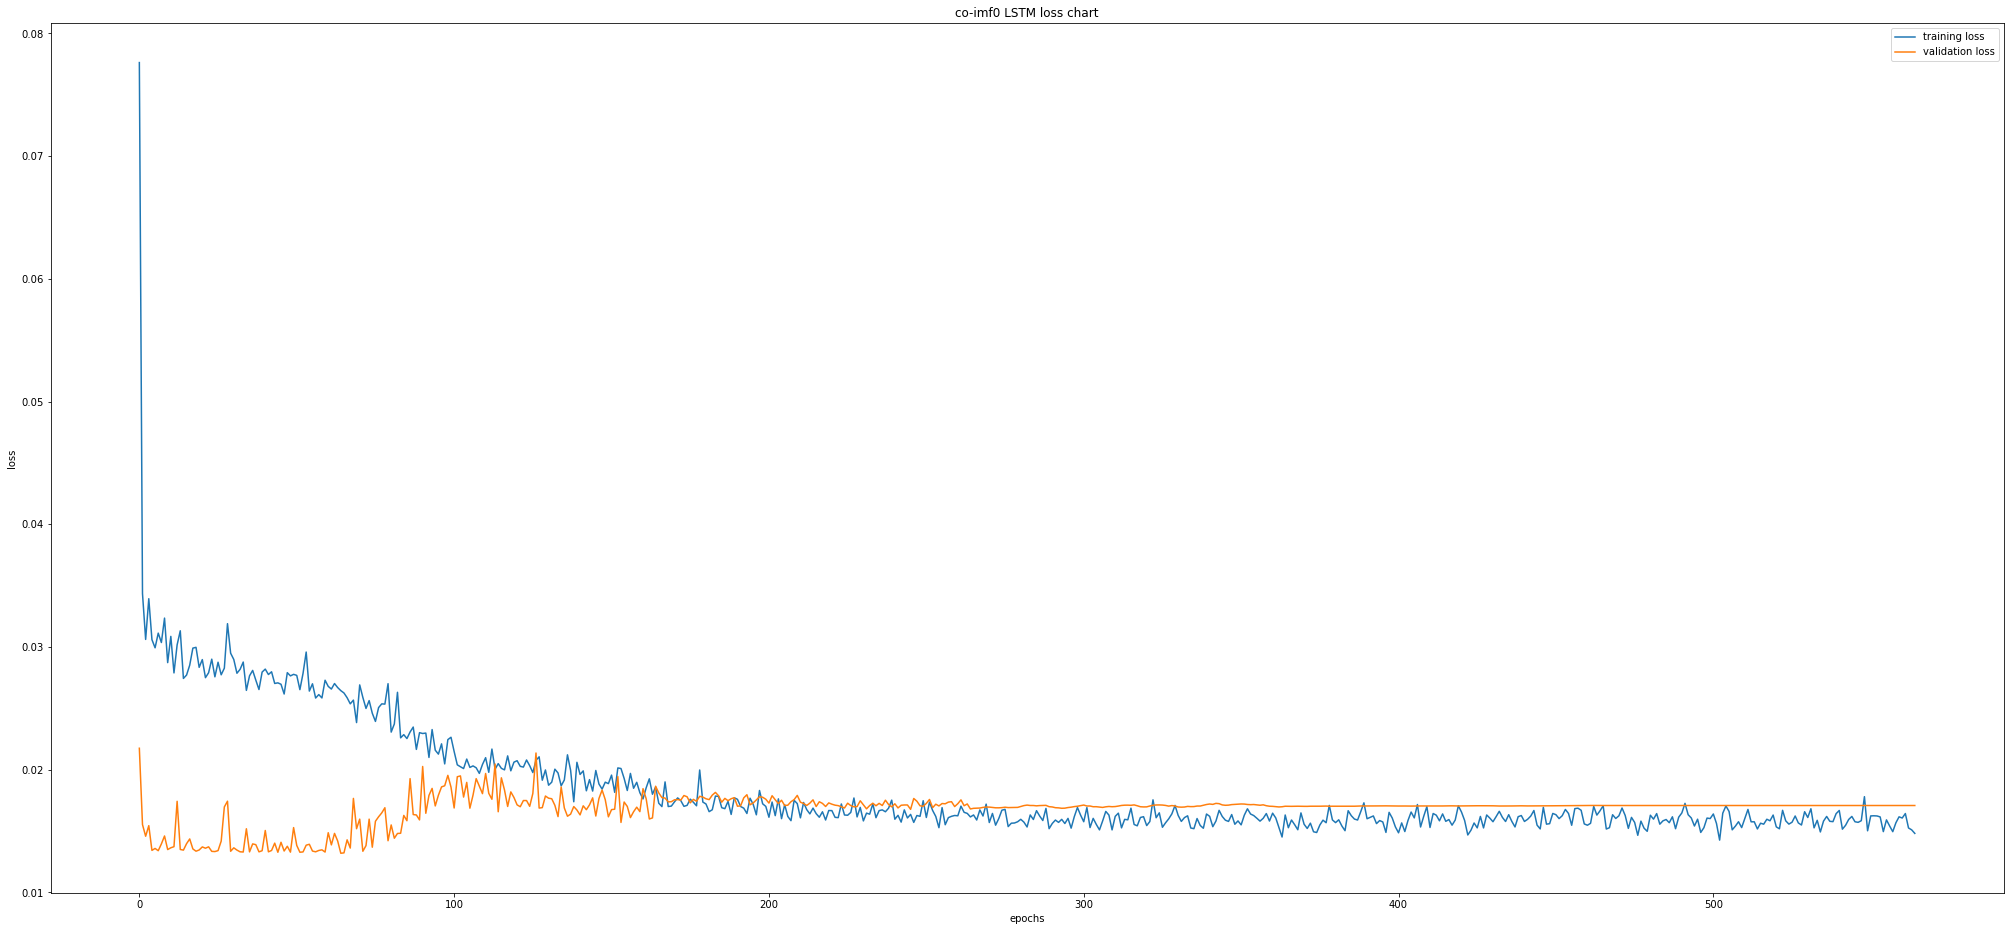

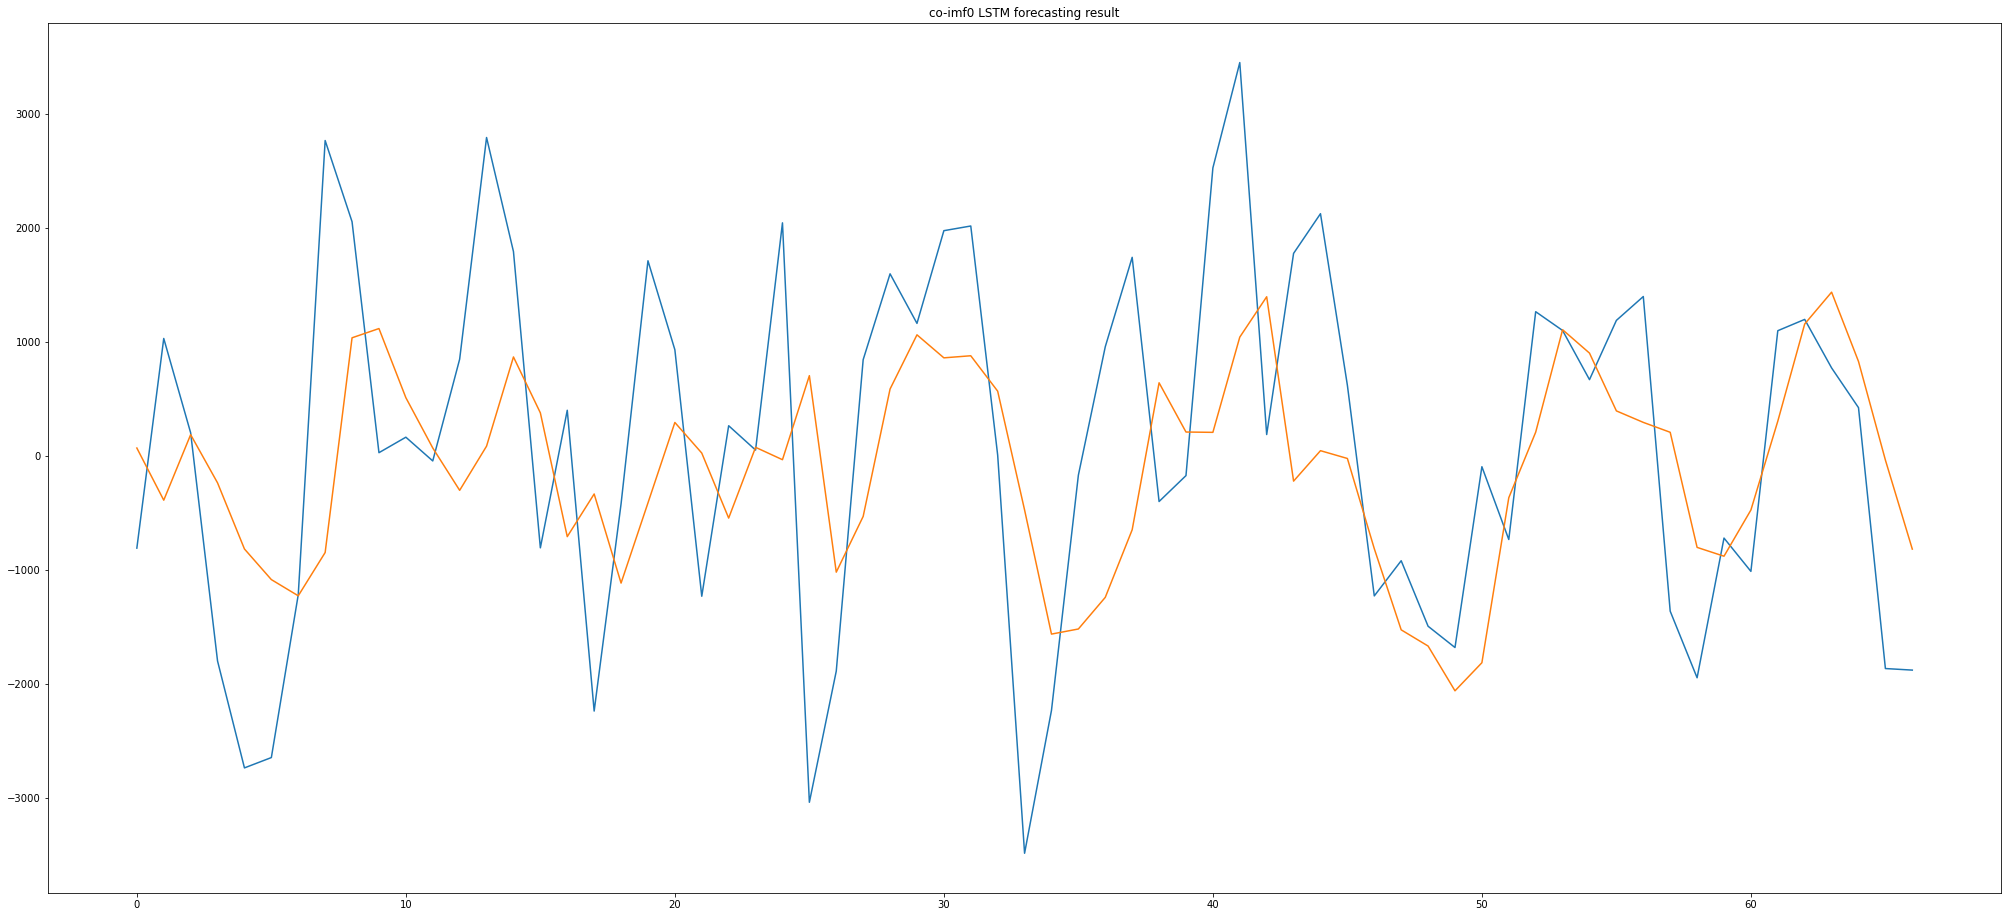

EMD_SE--IMF1

Input Shape: (30,1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 30, 128)           66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 64)            49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)    

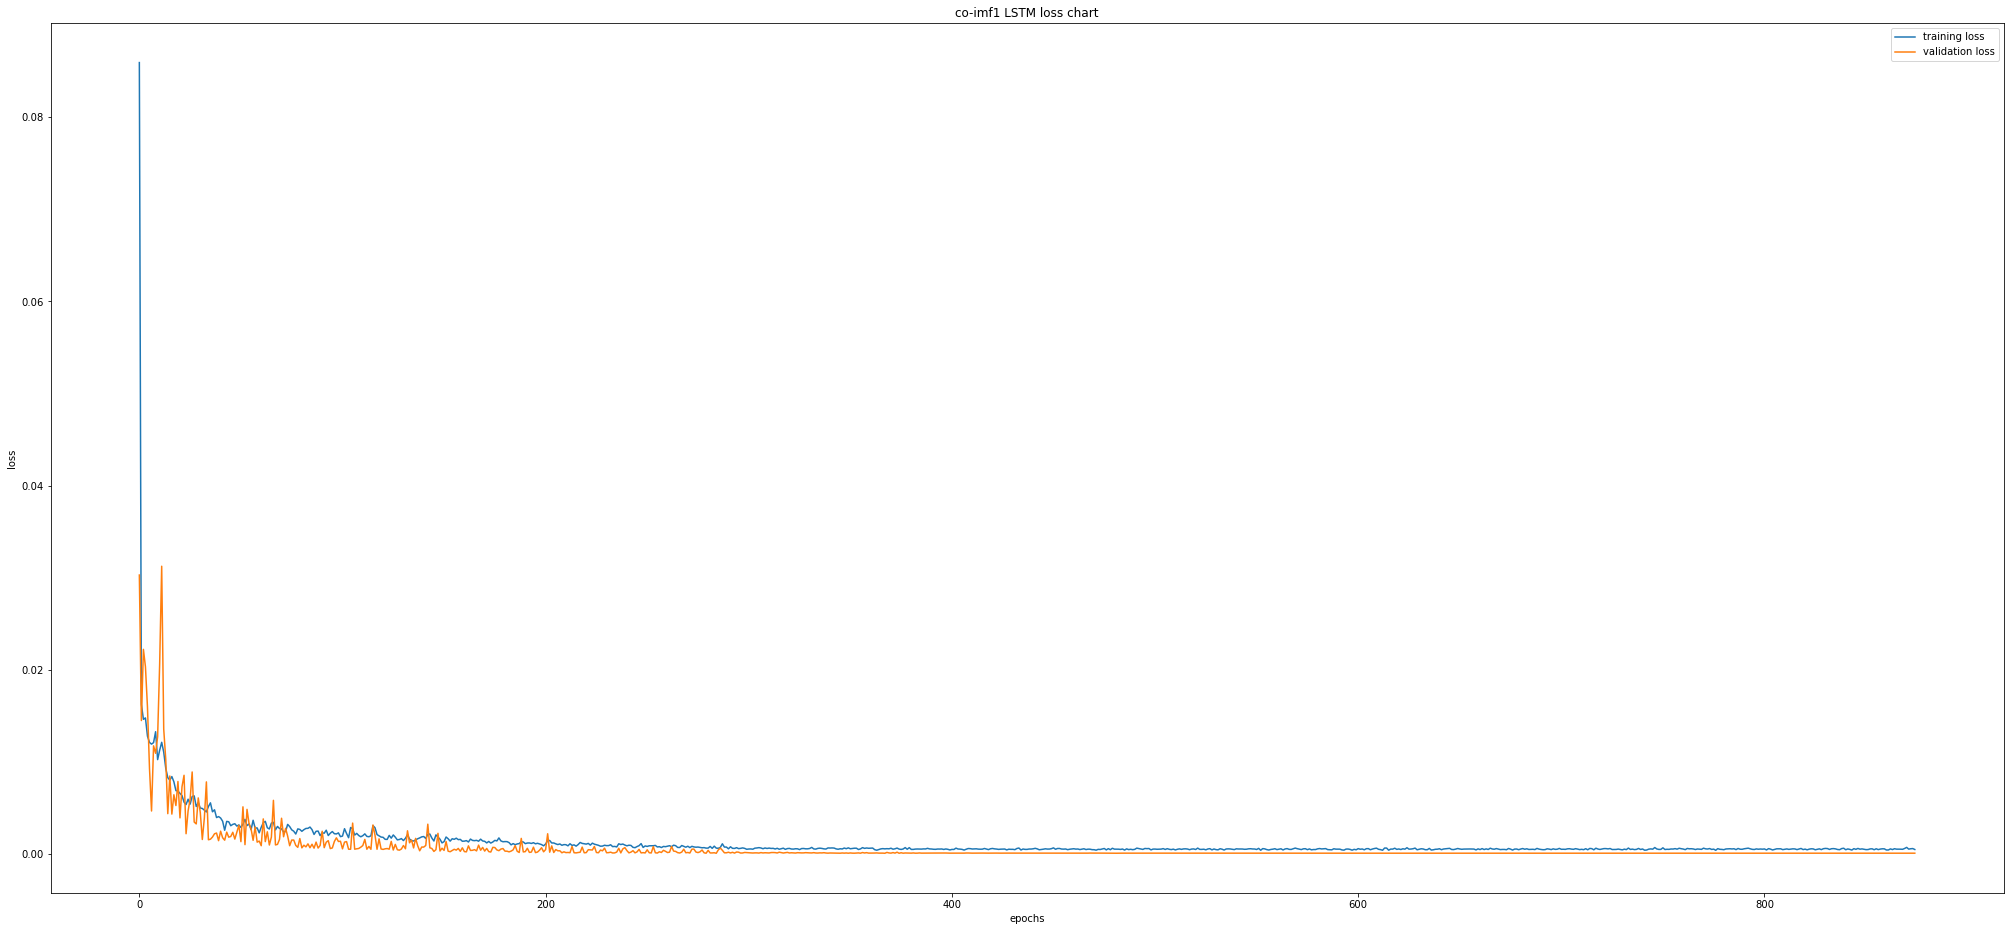

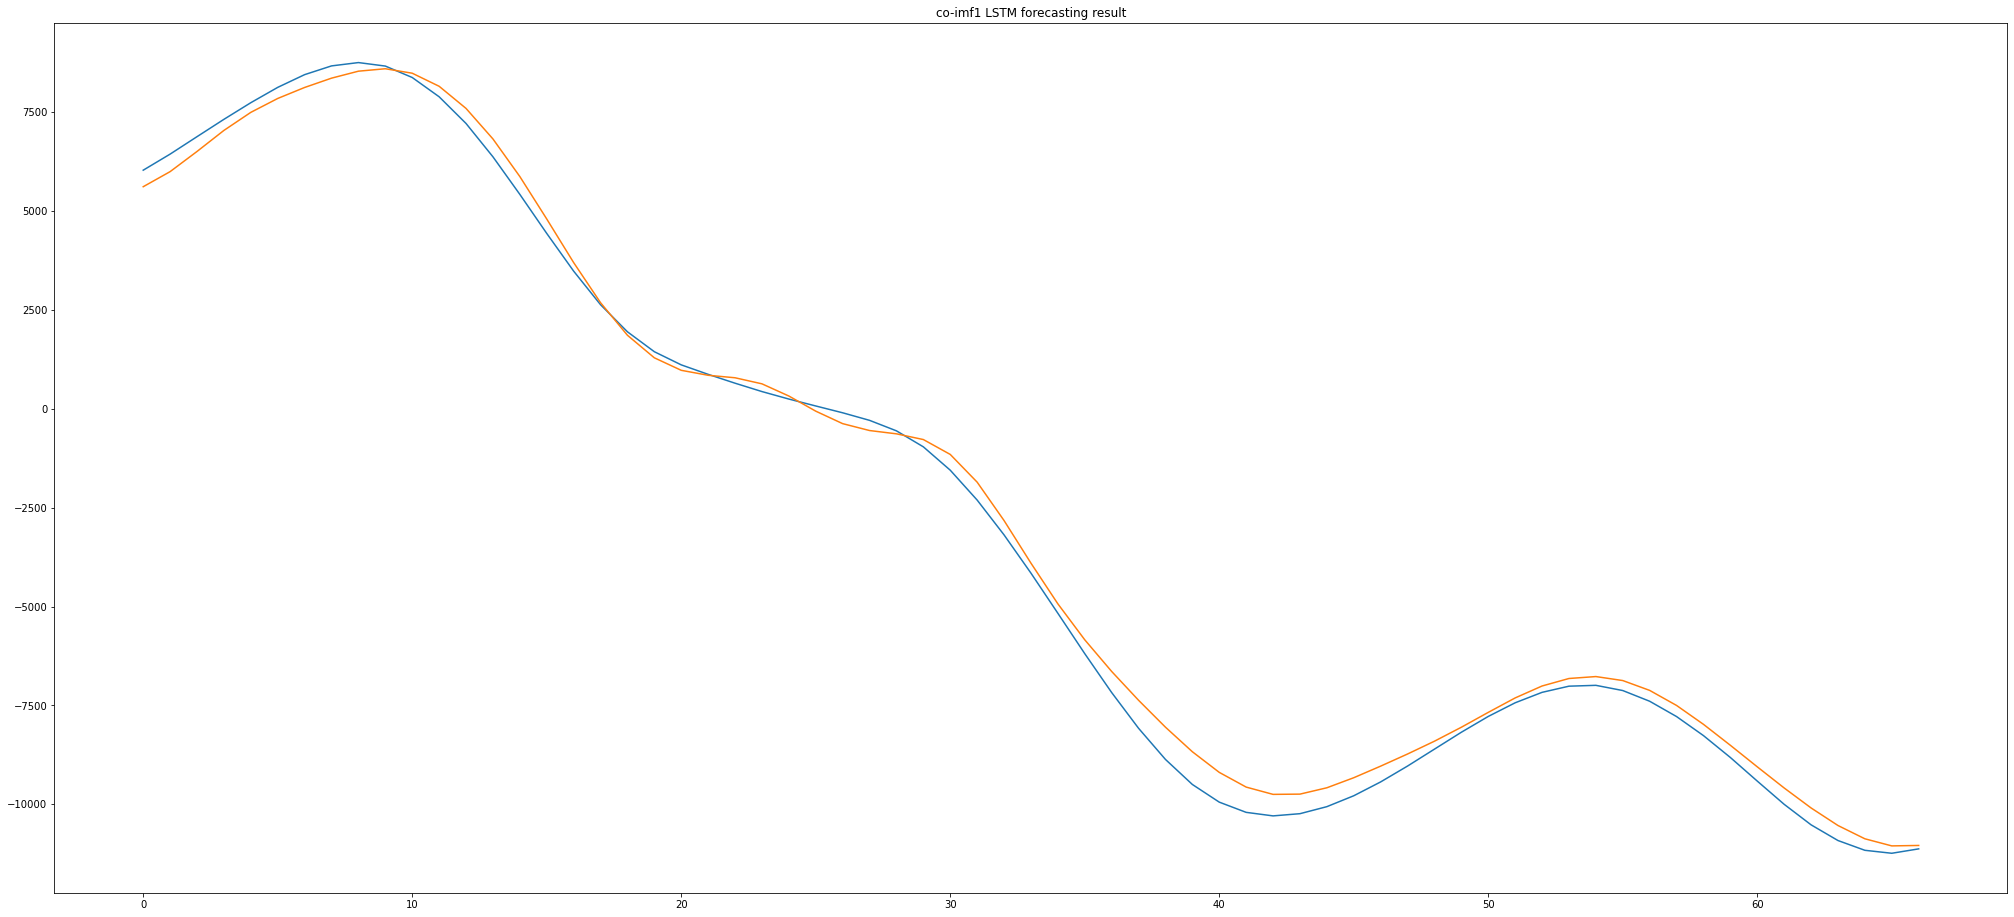

EMD_SE--IMF2

Input Shape: (30,1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 30, 128)           66560     
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30, 64)            49408     
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)    

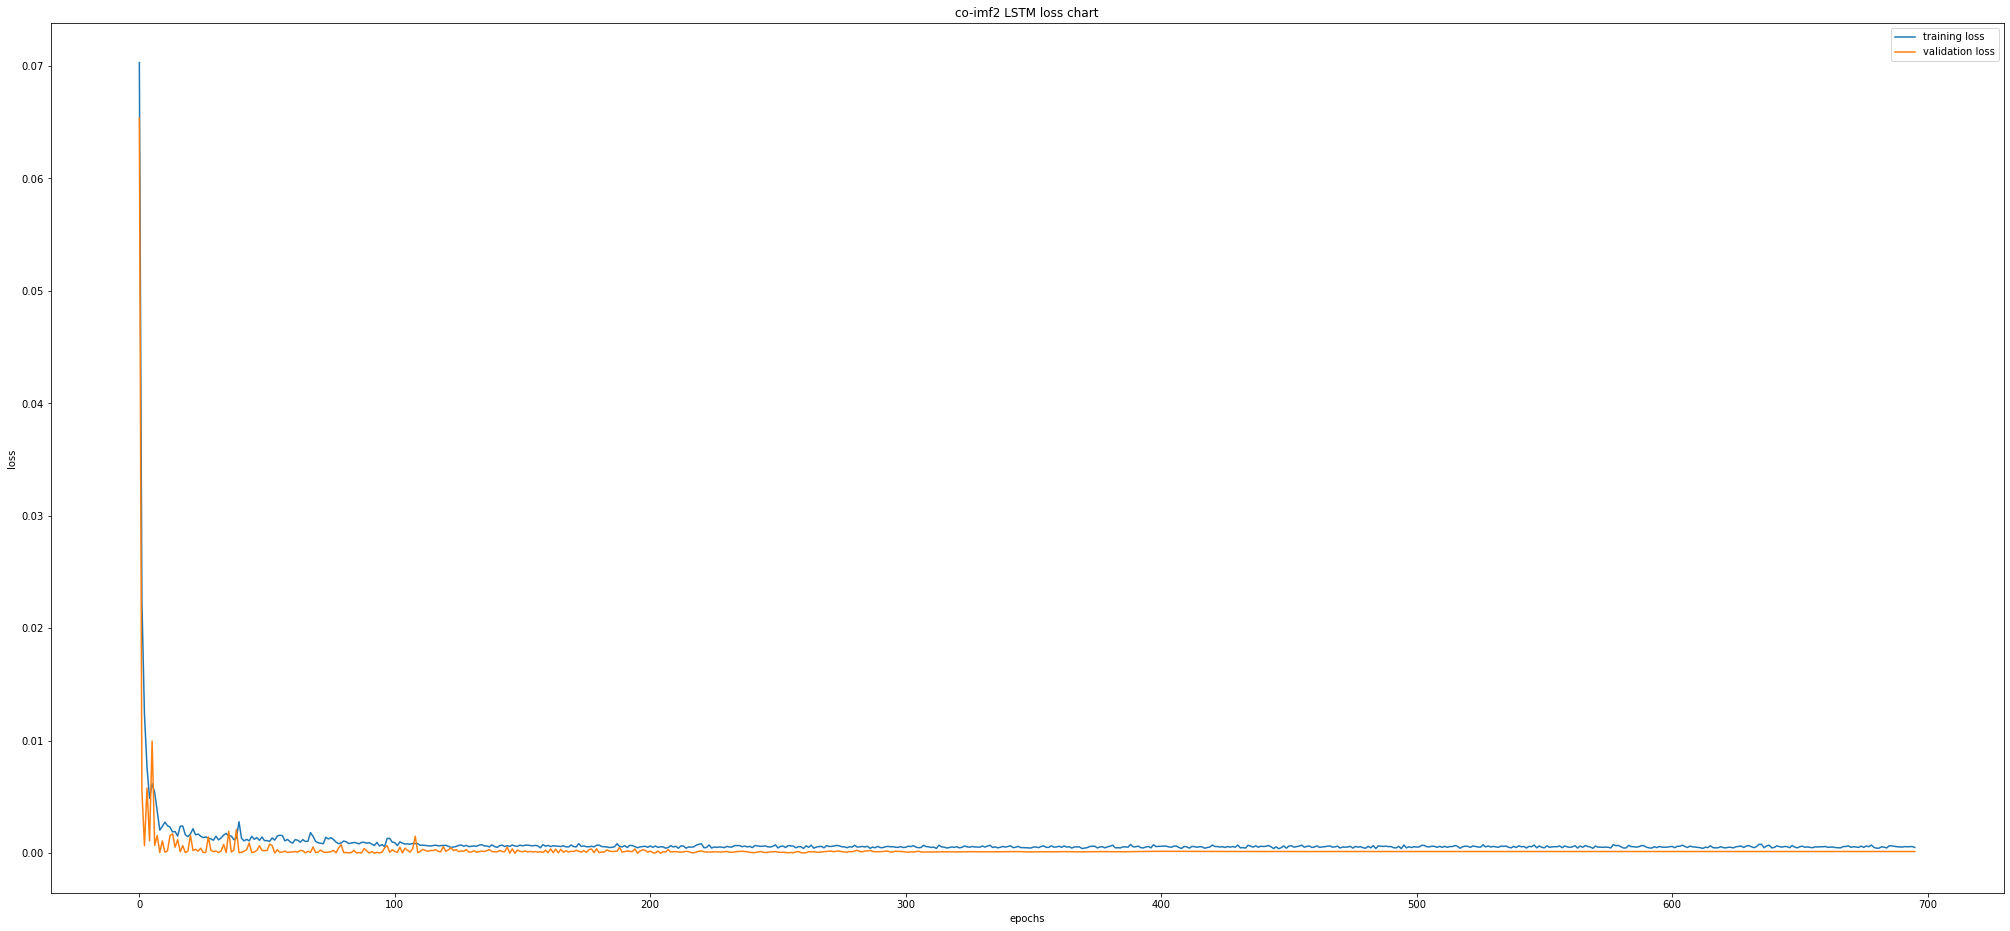

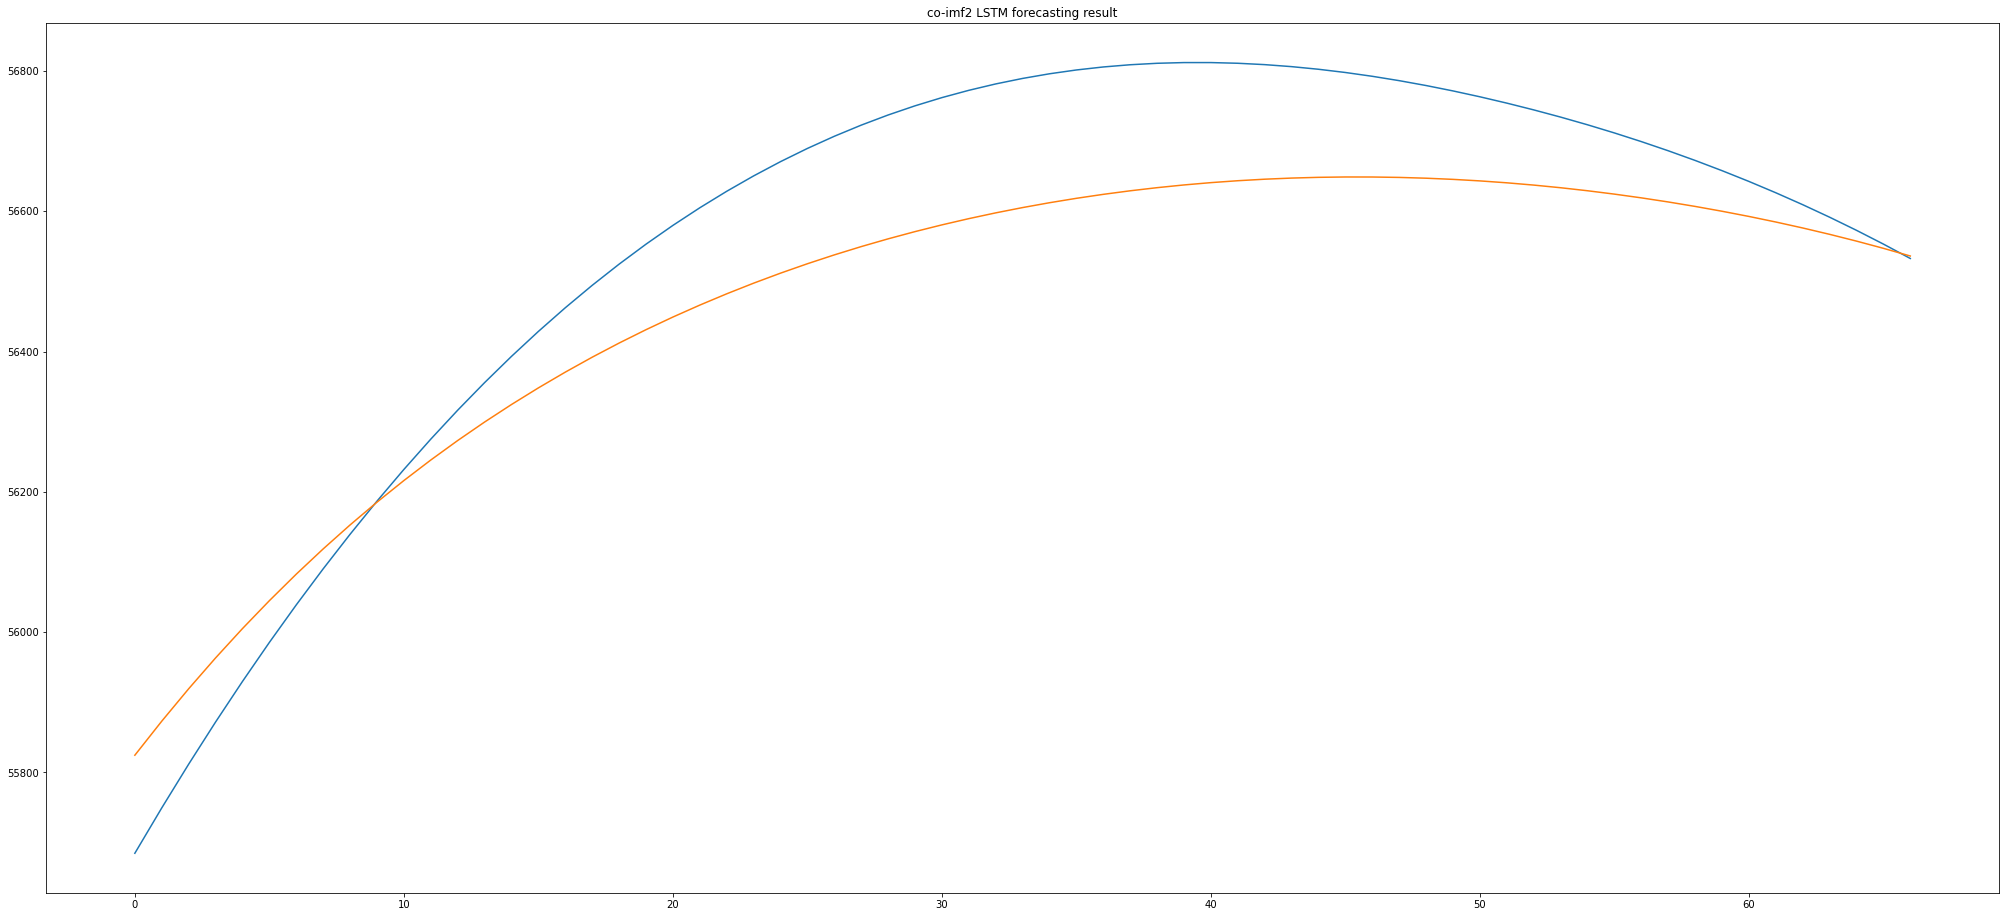

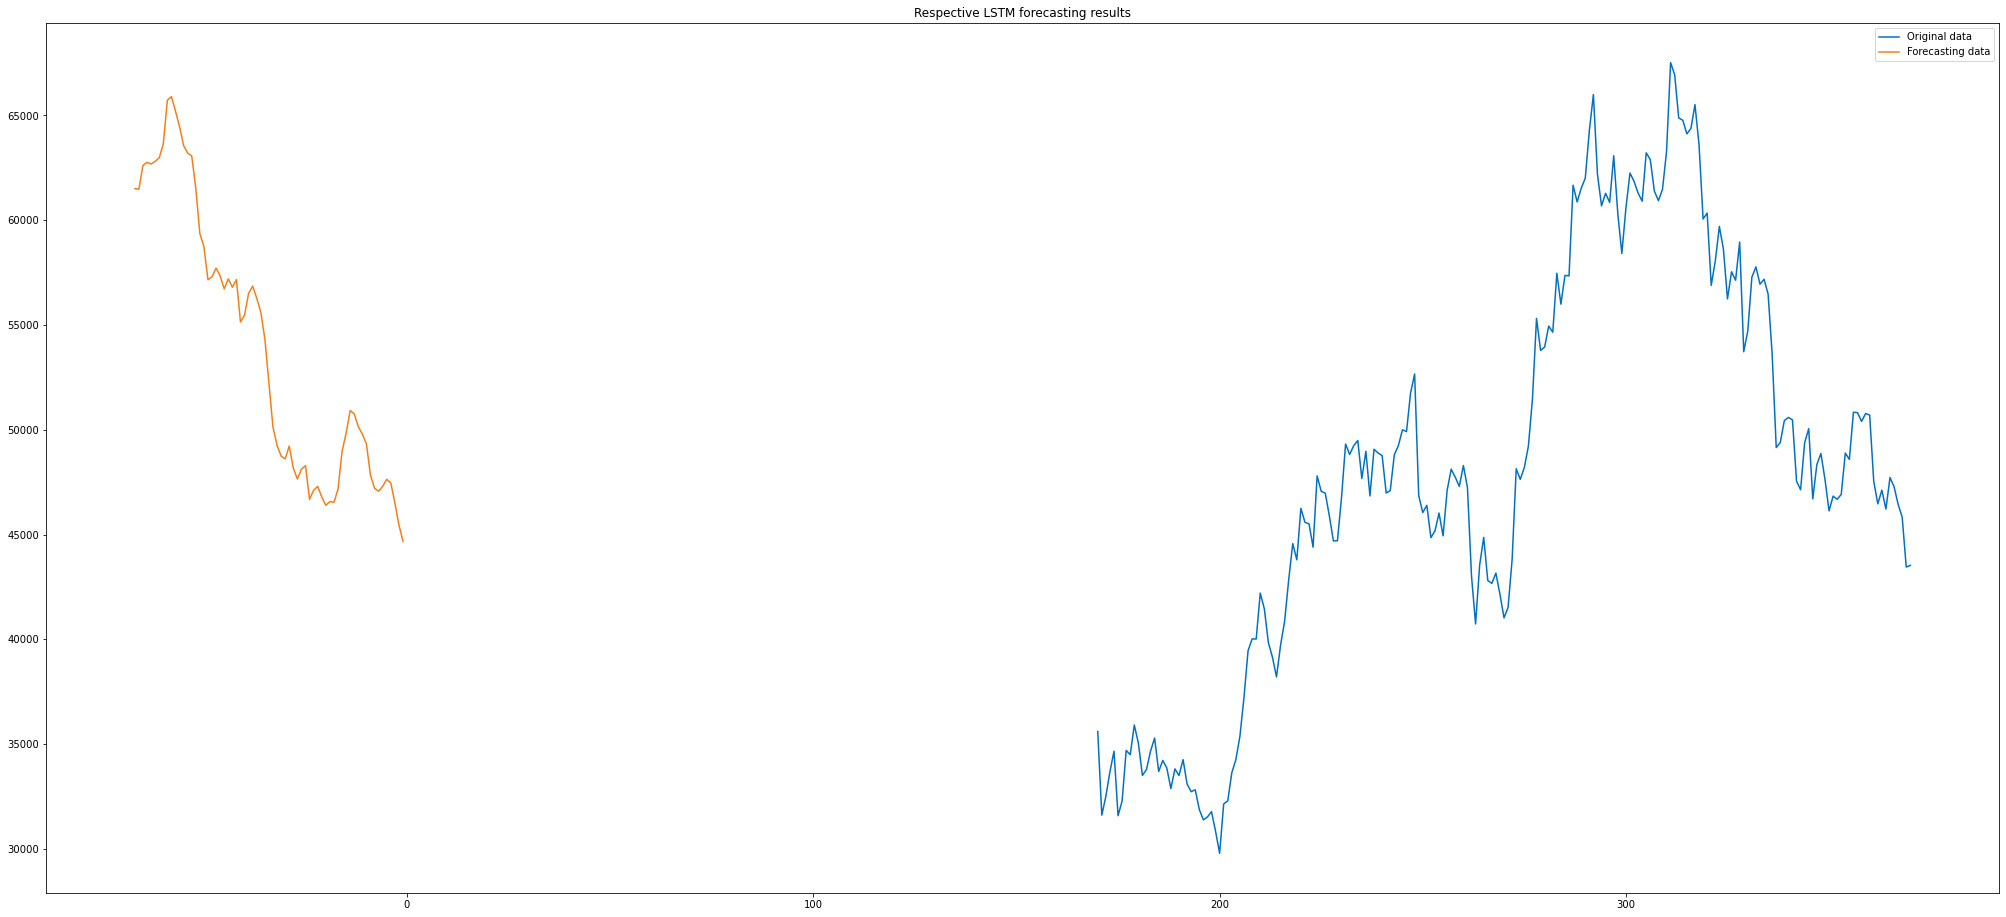

##################################
Model Evaluation with scale of input df
##################################
R2: 0.9572915952312823
RMSE: 1395.833633186232
MAE: 1148.2825023320888
MAPE: 2.1376764043588037
Running time: 601.446s
Respective LSTM Forecasting finished, check the logs data\subset\respective_emd_se222_log.csv


,co-imf0,co-imf1,co-imf2
0,69.256287,5616.645508,55824.593750
1,-387.852753,5998.072754,55873.089844
2,186.478607,6507.933105,55919.273438
3,-236.201813,7040.436523,55963.242188
4,-815.479553,7496.957031,56005.074219
...,...,...,...
62,1156.274414,-10093.019531,56576.226562
63,1435.140747,-10536.899414,56567.160156
64,827.784973,-10872.804688,56557.496094
65,-36.290035,-11052.454102,56547.207031


In [17]:
cl.declare_vars(mode='emd_se',form='222',epochs=1000, periods=PERIODS) 
cl.Respective_LSTM()

In [18]:
# Normalized Integration
df_res = pd.read_csv(PATH+'subset\\respective_emd_se222_pred.csv',header=0,index_col=0)
res_pred = df_res.T.sum().values
rate = series.max()-series.min()
series_nor = (series-series.min())/float(rate)
res_pred = (res_pred-series.min())/float(rate)
df_evl = cl.evl(series_nor[-PERIODS:].values,res_pred,scale='btc prices')

##################################
Model Evaluation with scale of btc prices
##################################
R2: 0.9572915900169868
RMSE: 0.03654575592997574
MAE: 0.030064364974203353
MAPE: 4.912346780667138


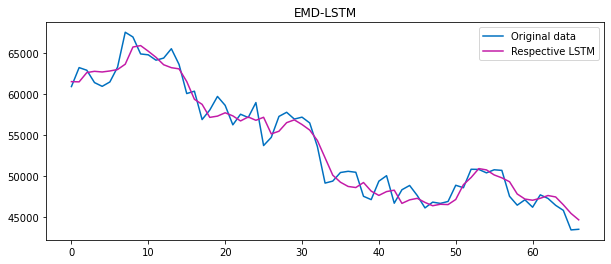

In [19]:
# Plot 

df_res = pd.read_csv('data/subset/respective_emd_se222_pred.csv',header=0,index_col=0)
res_pred = df_res.T.sum().values

# Plot original data by series
#PERIODS = periods # 
length = range(PERIODS)
fig = plt.figure(figsize=(10,4))
plt.plot(length, series[-PERIODS:], label= 'Original data', color='#0070C0') #F27F19 orange #0070C0 blue
plt.plot(length, res_pred, label= 'Respective LSTM', color='#C31BA7') #C31BA7 pink
plt.xlabel('')
plt.legend()
plt.title('EMD-LSTM')
plt.savefig('EMD-LSTM.svg', bbox_inches='tight')
plt.show()

In [20]:
res_pred

array([61510.49579 , 61483.31005 , 62613.6846  , 62767.47669 ,
       62686.55145 , 62809.1961  , 62983.2021  , 63633.9437  ,
       65726.0377  , 65901.1807  , 65213.2543  , 64471.5519  ,
       63568.02626 , 63209.86794 , 63065.7894  , 61525.99034 ,
       59361.90516 , 58742.4778  , 57157.9216  , 57309.79526 ,
       57716.26094 , 57339.51174 , 56722.98883 , 57205.04907 ,
       56802.584277, 57169.6158  , 55144.57338 , 55470.6505  ,
       56514.6061  , 56855.24384 , 56286.9377  , 55612.96896 ,
       54340.03474 , 52229.37063 , 50119.8332  , 49261.1482  ,
       48743.991   , 48612.4404  , 49224.2254  , 48175.62784 ,
       47654.18497 , 48119.6068  , 48291.0364  , 46683.29077 ,
       47111.459147, 47298.013097, 46800.7393  , 46395.5574  ,
       46576.2587  , 46535.0864  , 47155.139   , 48963.7113  ,
       49836.3994  , 50920.201   , 50759.85795 , 50147.66336 ,
       49792.7525  , 49319.51535 , 47826.8401  , 47212.58314 ,
       47065.61378 , 47301.43102 , 47639.4814  , 47465.

In [21]:
preds = Average()([res_pred, test_predict])

In [22]:
preds

<tf.Tensor: shape=(67,), dtype=float32, numpy=
array([60794.12 , 60375.195, 60760.453, 62030.07 , 61225.82 , 60793.906,
       60969.42 , 61917.19 , 63549.438, 65495.11 , 65706.63 , 63859.64 ,
       63086.81 , 62894.11 , 63010.336, 62589.383, 61540.52 , 59513.68 ,
       58159.254, 57357.266, 57409.203, 58076.6  , 57482.43 , 56597.062,
       56382.902, 56075.33 , 56142.953, 54937.53 , 54909.54 , 56055.414,
       56716.15 , 56104.47 , 55329.984, 53996.836, 51854.78 , 49269.297,
       48645.25 , 49071.418, 49797.668, 49054.562, 48025.766, 47728.566,
       47905.414, 47855.605, 47224.855, 47226.508, 47306.156, 47026.617,
       46511.164, 46628.95 , 46916.234, 47975.695, 48918.6  , 49706.4  ,
       50748.71 , 50488.254, 50023.76 , 50011.953, 49138.32 , 48048.19 ,
       46904.93 , 47009.42 , 46792.4  , 46981.77 , 46440.473, 45570.75 ,
       44734.1  ], dtype=float32)>

In [23]:
df_evl = cl.evl(testY,preds)

##################################
Model Evaluation with scale of 0 to 1
##################################
R2: 0.9598311468265245
RMSE: 1339.6206280452186
MAE: 1070.9025018949512
MAPE: 1.9497820855834167


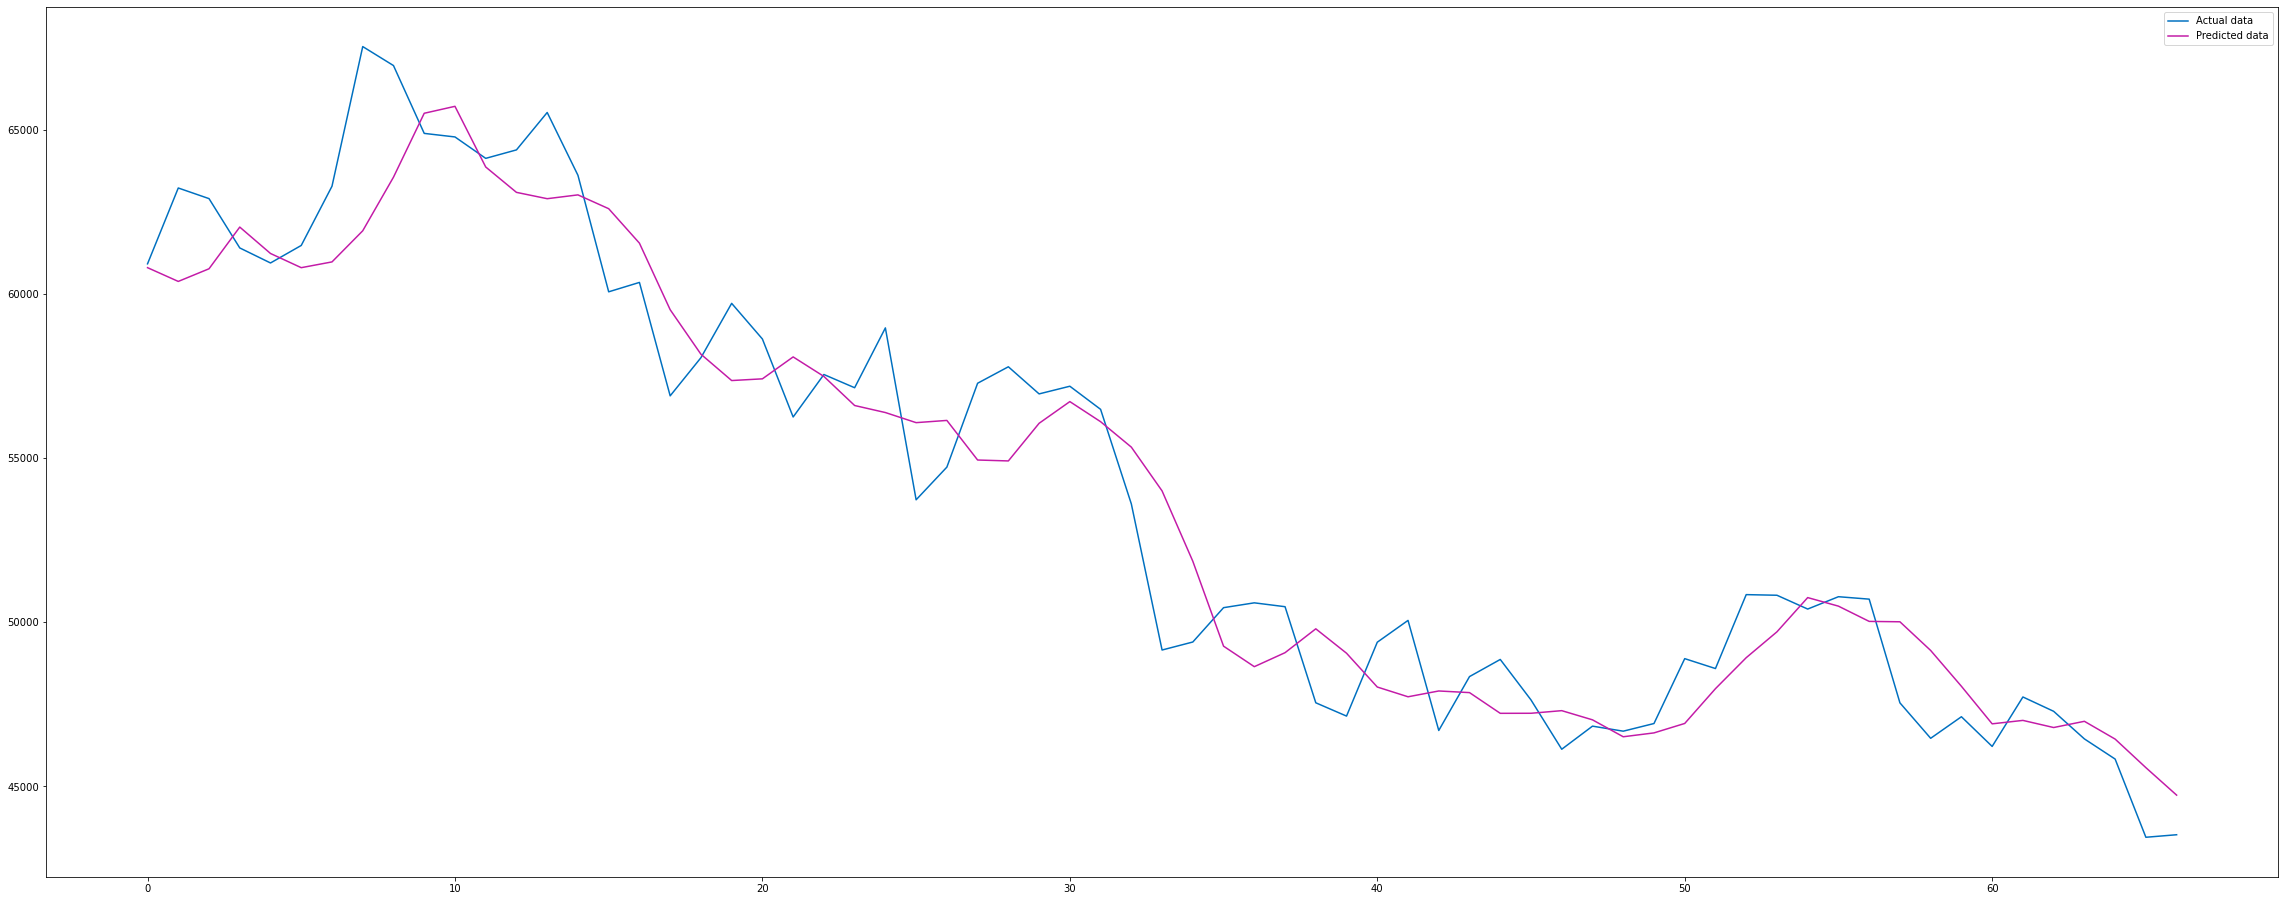

In [24]:
df_res = pd.read_csv('data/subset/respective_emd_se222_pred.csv',header=0,index_col=0)
res_pred = df_res.T.sum().values

# Plot original data by series
#PERIODS = periods # 
length = range(PERIODS)
fig = plt.figure(figsize=(40,16))
plt.plot(length, series[-PERIODS:], label= 'Actual data', color='#0070C0') #F27F19 orange #0070C0 blue
plt.plot(length, preds, label= 'Predicted data', color='#C31BA7') #C31BA7 pink
plt.xlabel('')
plt.legend()
#plt.title('EMD-LSTM')
plt.savefig('EMD-LSTM.png', bbox_inches='tight')
plt.show()

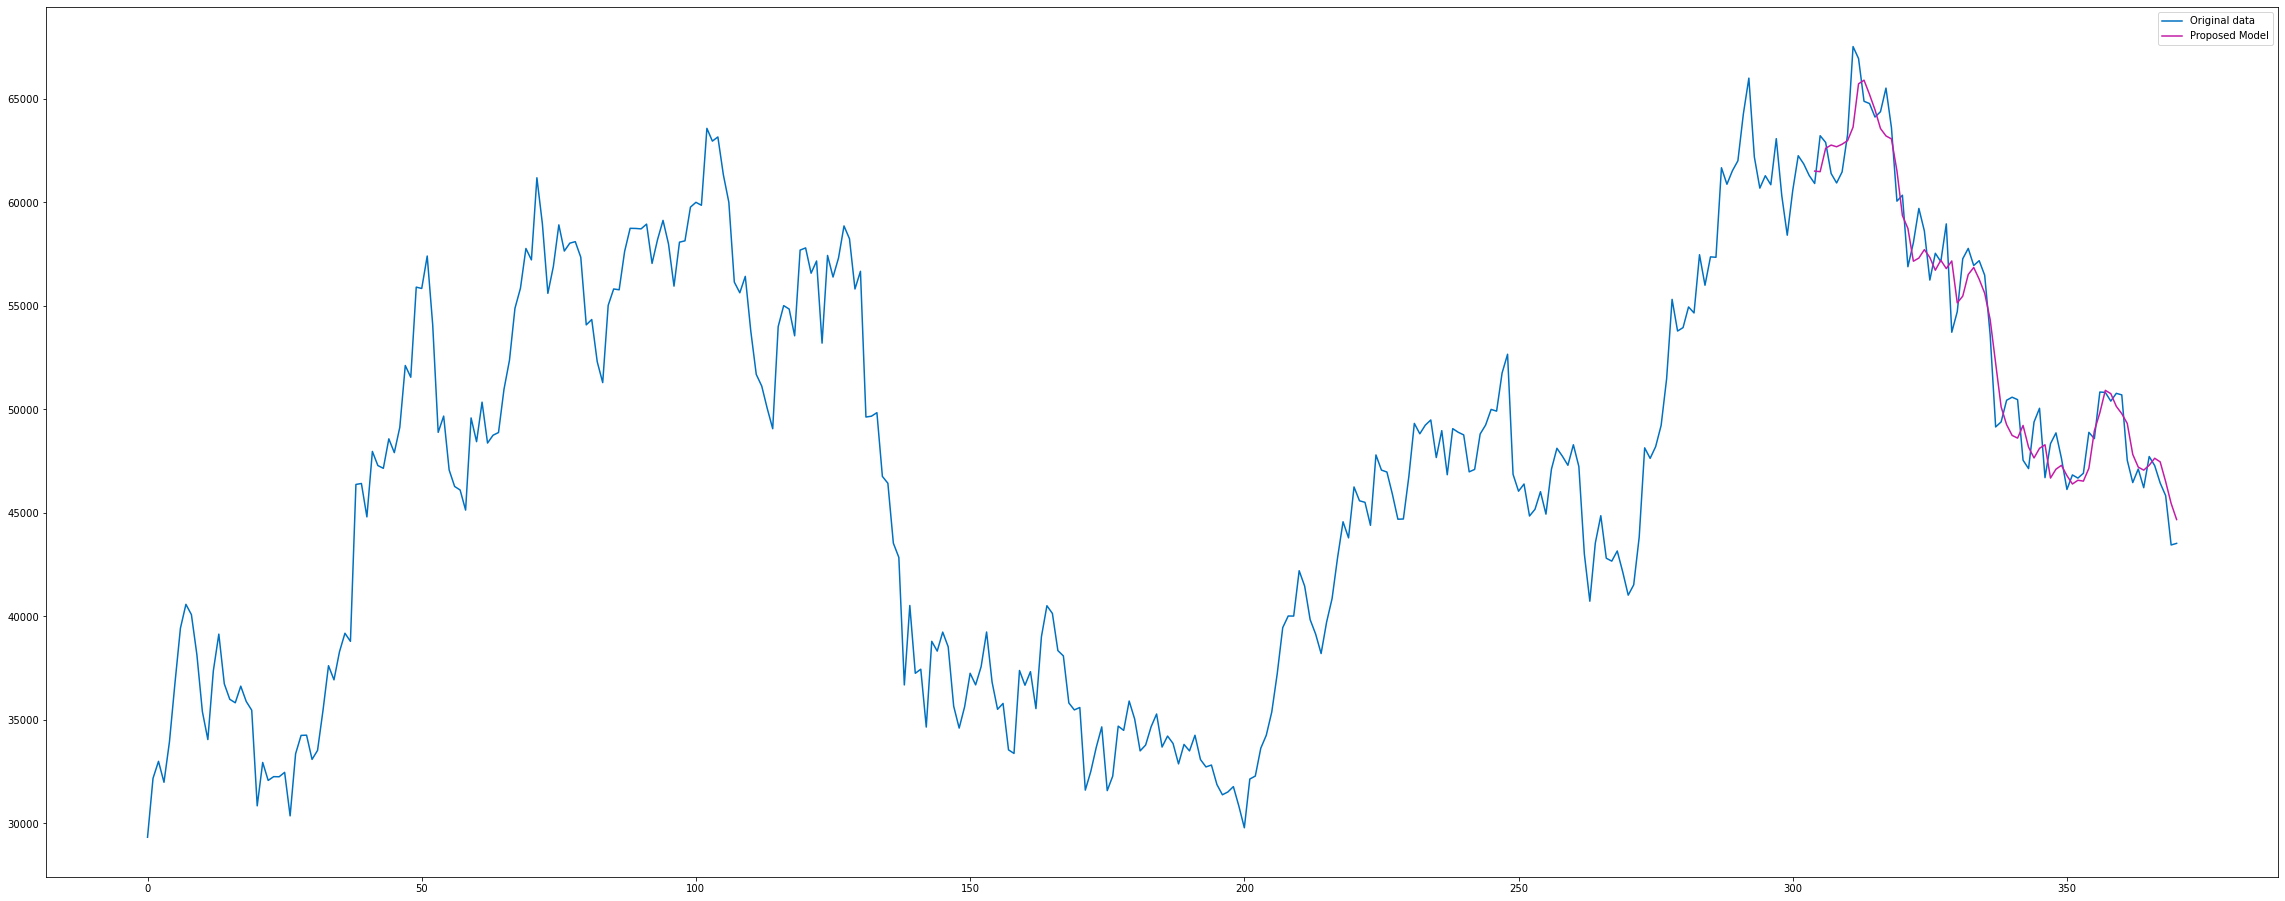

In [25]:
datelist = df[['date']]
x = np.arange(len(datelist))
#Plot original data by series
#PERIODS = periods # 
length = range(PERIODS)
fig = plt.figure(figsize=(40,16))
plt.plot(x, series, label= 'Original data', color='#0070C0') #F27F19 orange #0070C0 blue
plt.plot(x[-PERIODS:], res_pred, label= 'Proposed Model', color='#C31BA7') #C31BA7 pink
plt.xlabel('')
plt.legend()
#plt.title('EMD-LSTM')
plt.savefig('EMD-LSTM2.png', bbox_inches='tight')
plt.show()